# SVM

### In this notebook we are going to apply SVM for the merged csv file we have containing all people who recorded their voices along with teir voice recordings features.

Fisrt, we load the merged CSV and verify it makes sense: number of rows/columns, that person_id is unique (one row per person), and that label exists with PD/HC counts.

In [2]:
import pandas as pd
import numpy as np

CSV_PATH = "/content/all_features_merged_by_person.csv"  # change if your name differs
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns[:15].tolist(), "...")
print("person_id unique:", df["person_id"].nunique(), " / rows:", len(df))
print("person_id duplicates:", df["person_id"].duplicated().sum())

if "label" in df.columns:
    print("\nLabel counts:")
    print(df["label"].value_counts(dropna=False))
else:
    raise ValueError("No 'label' column found. Your file should contain label (PD/HC).")


Shape: (215, 37)
Columns: ['person_id', 'label', 'cpp__cpp_mean', 'cpp__cpp_median', 'cpp__cpp_std', 'd2_vowel_A__d2', 'd2_vowel_E__d2', 'd2_vowel_I__d2', 'd2_vowel_O__d2', 'd2_vowel_U__d2', 'hnr_stats_50_4000__hnr_mean_db', 'hnr_stats_50_4000__hnr_median_db', 'hnr_stats_50_4000__hnr_std_db', 'jitter_by_vowel__jitter_local', 'jitter_by_vowel__jitter_rap'] ...
person_id unique: 108  / rows: 215
person_id duplicates: 107

Label counts:
label
NaN    108
HC      55
PD      52
Name: count, dtype: int64


We keep only PD and HC rows, convert the label into a numeric target (y: PD=1, HC=0), drop ID/path columns that shouldn’t be used as features, and keep only numeric feature columns. We also replace inf with NaN so sklearn won’t crash.

In [3]:
df2 = df.copy()

# keep only PD/HC (drop UNK / missing)
df2 = df2[df2["label"].isin(["PD", "HC"])].copy()
df2["y"] = (df2["label"] == "PD").astype(int)  # PD=1, HC=0

# drop obvious non-feature columns
drop_cols = [c for c in ["person_id", "label", "file", "path"] if c in df2.columns]
X = df2.drop(columns=drop_cols + ["y"], errors="ignore")
y = df2["y"].values

# keep numeric features only
X = X.select_dtypes(include=[np.number]).copy()

# replace inf with NaN (important for sklearn)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

print("After filtering PD/HC:")
print("X shape:", X.shape, "| y shape:", y.shape)
print("Missing fraction (overall):", float(X.isna().mean().mean()))


After filtering PD/HC:
X shape: (107, 35) | y shape: (107,)
Missing fraction (overall): 0.18558077436582113


Some features exist only for some people → many NaNs. Columns that are mostly missing add noise and make SVM unstable. We drop columns with >60% missingness.

In [4]:
missing_per_col = X.isna().mean()
keep_cols = missing_per_col[missing_per_col <= 0.60].index  # keep cols with <=60% missing
X = X[keep_cols].copy()

print("Kept columns:", X.shape[1])
print("Top 10 most-missing kept cols:")
print(X.isna().mean().sort_values(ascending=False).head(10))


Kept columns: 33
Top 10 most-missing kept cols:
pause_features_espontanea__pause_mean_sec                0.317757
f0_variability_espontanea__f0_cv                         0.317757
pause_features_espontanea__pause_total_sec               0.317757
speech_rate_proxy_espontanea__mean_speech_segment_sec    0.317757
speech_rate_proxy_espontanea__speech_segment_rate        0.317757
speech_rate_proxy_espontanea__duration_sec               0.317757
pause_features_espontanea__pause_ratio                   0.317757
speech_rate_proxy_espontanea__articulation_rate          0.317757
speech_rate_proxy_espontanea__speech_time_sec            0.317757
f0_variability_espontanea__f0_mean_hz                    0.317757
dtype: float64


In [8]:
counts = df2["label"].value_counts()
print(counts)
print("Imbalance ratio (majority/minority):", counts.max()/counts.min())


label
HC    55
PD    52
Name: count, dtype: int64
Imbalance ratio (majority/minority): 1.0576923076923077


55 HC and 52 PD.This dataset is considered blanaced.

Split into Train+Val and Test

In [5]:
from sklearn.model_selection import train_test_split


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train+Val:", X_trainval.shape, "Test:", X_test.shape)
print("PD rate Train+Val:", y_trainval.mean(), "PD rate Test:", y_test.mean())


Train+Val: (85, 33) Test: (22, 33)
PD rate Train+Val: 0.4823529411764706 PD rate Test: 0.5


Compute correlation matrix (after imputation)

In [9]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Impute so correlation has no NaNs
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

corr = X_imp.corr(method="pearson")
print("Corr matrix shape:", corr.shape)


Corr matrix shape: (33, 33)


Correlation heatmap

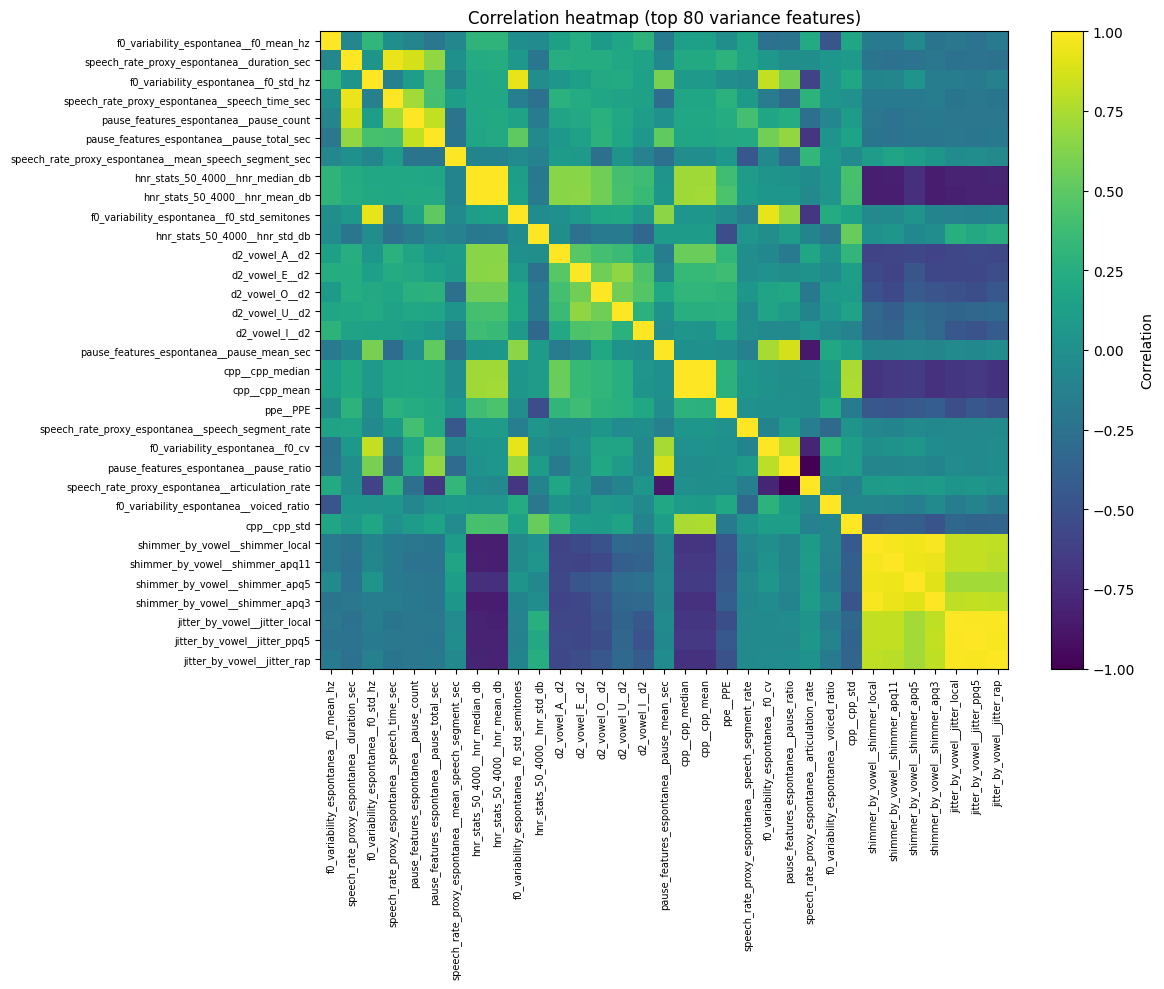

In [10]:
import matplotlib.pyplot as plt

N = 80  # adjust (50–120 is usually readable)
top_cols = X_imp.var().sort_values(ascending=False).head(N).index
corr_sub = corr.loc[top_cols, top_cols]

plt.figure(figsize=(12, 10))
plt.imshow(corr_sub.values, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(top_cols)), top_cols, rotation=90, fontsize=7)
plt.yticks(range(len(top_cols)), top_cols, fontsize=7)
plt.title(f"Correlation heatmap (top {N} variance features)")
plt.tight_layout()
plt.show()


This drops one of each pair with |corr| >= threshold, choosing to drop the feature with more missingness.

In [11]:
threshold = 0.95

# upper triangle of absolute correlation
upper = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# missingness used to decide which one to drop (from original X, before imputation)
miss = X.isna().mean()

to_drop = set()
pairs = []

for col in upper.columns:
    high = upper[col][upper[col] >= threshold].dropna()
    for row, val in high.items():
        # decide which to drop: higher missingness gets dropped
        drop = col if miss.get(col, 0) >= miss.get(row, 0) else row
        keep = row if drop == col else col
        to_drop.add(drop)
        pairs.append((keep, drop, float(val)))

print("Highly correlated pairs found:", len(pairs))
print("Features to drop:", len(to_drop))
print("Example pairs (keep, drop, |corr|):", pairs[:10])

X_reduced = X.drop(columns=list(to_drop), errors="ignore")
print("X reduced shape:", X_reduced.shape)


Highly correlated pairs found: 10
Features to drop: 8
Example pairs (keep, drop, |corr|): [('cpp__cpp_mean', 'cpp__cpp_median', 0.999280726399566), ('hnr_stats_50_4000__hnr_mean_db', 'hnr_stats_50_4000__hnr_median_db', 0.9935110482016056), ('jitter_by_vowel__jitter_local', 'jitter_by_vowel__jitter_rap', 0.9916182977774549), ('jitter_by_vowel__jitter_local', 'jitter_by_vowel__jitter_ppq5', 0.9890228362852207), ('jitter_by_vowel__jitter_rap', 'jitter_by_vowel__jitter_ppq5', 0.9770654876396319), ('shimmer_by_vowel__shimmer_local', 'shimmer_by_vowel__shimmer_apq3', 0.9822590651404783), ('shimmer_by_vowel__shimmer_local', 'shimmer_by_vowel__shimmer_apq5', 0.9578529016390392), ('shimmer_by_vowel__shimmer_local', 'shimmer_by_vowel__shimmer_apq11', 0.97424604204085), ('shimmer_by_vowel__shimmer_apq5', 'shimmer_by_vowel__shimmer_apq11', 0.9508028247392747), ('pause_features_espontanea__pause_ratio', 'speech_rate_proxy_espontanea__articulation_rate', 0.9961438929756716)]
X reduced shape: (107, 2

In [12]:
import numpy as np
import pandas as pd

# groups = person_id (even if it's unique per row, this matches the notebook style)
groups = df2["person_id"].astype(str).reset_index(drop=True)
X2 = X.reset_index(drop=True)
y2 = np.asarray(y)

# Group-aware splitter (fallback to StratifiedKFold if not available)
try:
    from sklearn.model_selection import StratifiedGroupKFold
    outer = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=42)
    trainval_idx, test_idx = next(outer.split(X2, y2, groups))
    X_trainval, X_test = X2.iloc[trainval_idx], X2.iloc[test_idx]
    y_trainval, y_test = y2[trainval_idx], y2[test_idx]
    g_trainval, g_test = groups.iloc[trainval_idx], groups.iloc[test_idx]

    inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=43)
    tr_idx_local, val_idx_local = next(inner.split(X_trainval, y_trainval, g_trainval))
    X_train, X_val = X_trainval.iloc[tr_idx_local], X_trainval.iloc[val_idx_local]
    y_train, y_val = y_trainval[tr_idx_local], y_trainval[val_idx_local]
    g_train, g_val = g_trainval.iloc[tr_idx_local], g_trainval.iloc[val_idx_local]

except Exception:
    from sklearn.model_selection import train_test_split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X2, y2, test_size=0.2, random_state=42, stratify=y2
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=43, stratify=y_trainval
    )

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("PD rate Train/Val/Test:", y_train.mean(), y_val.mean(), y_test.mean())


Train: (71, 33) Val: (18, 33) Test: (18, 33)
PD rate Train/Val/Test: 0.49295774647887325 0.5 0.4444444444444444


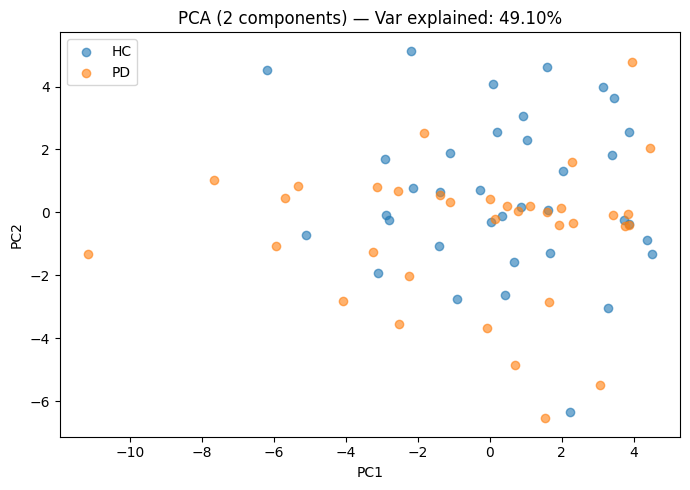

In [13]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

imp = SimpleImputer(strategy="median")
sc = StandardScaler()

Xtr = sc.fit_transform(imp.fit_transform(X_train))
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xtr)
total_var = pca.explained_variance_ratio_.sum() * 100

plt.figure(figsize=(7,5))
plt.scatter(X_pca[y_train==0,0], X_pca[y_train==0,1], alpha=0.6, label="HC")
plt.scatter(X_pca[y_train==1,0], X_pca[y_train==1,1], alpha=0.6, label="PD")
plt.title(f"PCA (2 components) — Var explained: {total_var:.2f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.tight_layout(); plt.show()


In [14]:
import numpy as np

linear_configs = [
    {"kernel": "linear", "C": C}
    for C in np.logspace(-2, 3, 16)
]

rbf_configs = [
    {"kernel": "rbf", "C": C, "gamma": gamma}
    for C in np.logspace(-2, 3, 15)
    for gamma in ["scale", "auto"] + list(np.logspace(-4, 1, 10))
]

poly_configs = [
    {"kernel": "poly", "degree": degree, "C": C, "gamma": gamma, "coef0": coef0}
    for degree in [2, 3]
    for C in np.logspace(-2, 3, 16)
    for gamma in ["scale", "auto"]
    for coef0 in [0, 1]
]

all_configs = linear_configs + rbf_configs + poly_configs
print("Total configurations:", len(all_configs))


Total configurations: 324


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

results = []
best_score = -1
best_params = None
best_model = None

print("Training SVM models...")

for i, cfg in enumerate(all_configs):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i+1}/{len(all_configs)}")

    try:
        model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("svm", SVC(
                probability=True,
                class_weight="balanced",
                random_state=42,
                max_iter=5000,
                **cfg
            ))
        ])

        model.fit(X_train, y_train)

        y_tr = model.predict(X_train)
        y_va = model.predict(X_val)

        tr_acc = accuracy_score(y_train, y_tr)
        va_acc = accuracy_score(y_val, y_va)
        va_f1  = f1_score(y_val, y_va)  # PD is positive (1)

        results.append({
            "kernel": cfg.get("kernel"),
            "C": cfg.get("C"),
            "gamma": cfg.get("gamma"),
            "degree": cfg.get("degree"),
            "coef0": cfg.get("coef0"),
            "train_accuracy": tr_acc,
            "val_accuracy": va_acc,
            "val_f1": va_f1,
            "train_val_gap": tr_acc - va_acc
        })

        if va_f1 > best_score:
            best_score = va_f1
            best_params = cfg
            best_model = model

    except Exception as e:
        # skip configs that fail
        continue

print("\nBest VAL F1:", best_score)
print("Best params:", best_params)


Training SVM models...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider

Progress: 50/324
Progress: 100/324
Progress: 150/324
Progress: 200/324
Progress: 250/324
Progress: 300/324

Best VAL F1: 0.9
Best params: {'kernel': 'poly', 'degree': 2, 'C': np.float64(1.0), 'gamma': 'scale', 'coef0': 0}


In [16]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

results_df = pd.DataFrame(results)
results_df.to_csv("/content/svm_section3_results.csv", index=False)
print("Saved: /content/svm_section3_results.csv")

print("\n=== PERFORMANCE BY KERNEL ===")
print(results_df.groupby("kernel")[["val_accuracy","val_f1","train_val_gap"]].agg(["mean","max","std"]).round(4))

# Test evaluation
y_test_pred = best_model.predict(X_test)

print("\n=== TEST REPORT (best model) ===")
print(classification_report(y_test, y_test_pred, target_names=["HC","PD"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


Saved: /content/svm_section3_results.csv

=== PERFORMANCE BY KERNEL ===
       val_accuracy                  val_f1                 train_val_gap  \
               mean     max     std    mean     max     std          mean   
kernel                                                                      
linear       0.6250  0.7778  0.1192  0.5809  0.7778  0.1509        0.2447   
poly         0.6910  0.8889  0.1203  0.6009  0.9000  0.2519        0.1699   
rbf          0.5935  0.8889  0.1201  0.3332  0.8750  0.3317        0.1939   

                        
           max     std  
kernel                  
linear  0.4014  0.1161  
poly    0.3748  0.1195  
rbf     0.5000  0.1766  

=== TEST REPORT (best model) ===
              precision    recall  f1-score   support

          HC       1.00      0.50      0.67        10
          PD       0.62      1.00      0.76         8

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted 

In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix

def best_f1_threshold(y_true, y_prob):
    p, r, th = precision_recall_curve(y_true, y_prob)
    if len(th) == 0:
        return 0.5, 0.0
    f1s = (2*p[:-1]*r[:-1])/(p[:-1]+r[:-1]+1e-12)
    i = int(np.nanargmax(f1s))
    return float(th[i]), float(f1s[i])

val_prob = best_model.predict_proba(X_val)[:, 1]
thr, val_best_f1 = best_f1_threshold(y_val, val_prob)
print("Best VAL threshold:", thr, "| VAL best F1:", val_best_f1)

test_prob = best_model.predict_proba(X_test)[:, 1]
test_pred_thr = (test_prob >= thr).astype(int)

print("\n=== TEST REPORT (thresholded) ===")
print(classification_report(y_test, test_pred_thr, target_names=["HC","PD"]))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_thr))


Best VAL threshold: 0.48979876960255575 | VAL best F1: 0.899999999999505

=== TEST REPORT (thresholded) ===
              precision    recall  f1-score   support

          HC       1.00      0.50      0.67        10
          PD       0.62      1.00      0.76         8

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18

Confusion matrix:
 [[5 5]
 [0 8]]


Saved: /content/svm_perm_importance.csv
                                              feature  importance       std
32  speech_rate_proxy_espontanea__mean_speech_segm...    0.111111  0.065734
31  speech_rate_proxy_espontanea__speech_segment_rate    0.100000  0.048432
28         speech_rate_proxy_espontanea__duration_sec    0.083333  0.056928
29      speech_rate_proxy_espontanea__speech_time_sec    0.083333  0.051220
24             pause_features_espontanea__pause_count    0.061111  0.058002
30    speech_rate_proxy_espontanea__articulation_rate    0.055556  0.024845
27             pause_features_espontanea__pause_ratio    0.055556  0.024845
19              f0_variability_espontanea__f0_mean_hz    0.050000  0.016667
6                                      d2_vowel_O__d2    0.044444  0.033333
26         pause_features_espontanea__pause_total_sec    0.038889  0.035573
17                     shimmer_by_vowel__shimmer_apq5    0.033333  0.036851
14                                           ppe

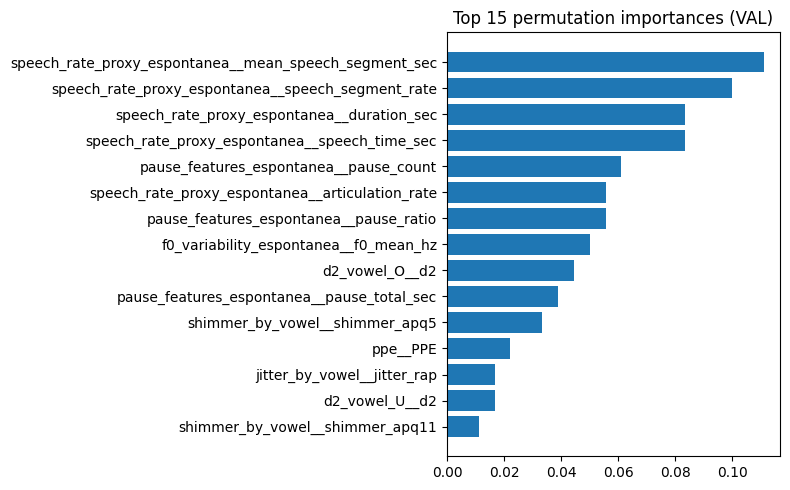

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

perm = permutation_importance(
    best_model, X_val, y_val,
    n_repeats=10, random_state=42, n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

importance_df.to_csv("/content/svm_perm_importance.csv", index=False)
print("Saved: /content/svm_perm_importance.csv")

print(importance_df.head(15))

plt.figure(figsize=(8,5))
top = importance_df.head(15)[::-1]
plt.barh(top["feature"], top["importance"])
plt.title("Top 15 permutation importances (VAL)")
plt.tight_layout()
plt.show()
